Volumes dir /cis/home/jteneggi/repo/brainlit/experiments/soma_detection/data/volumes/150


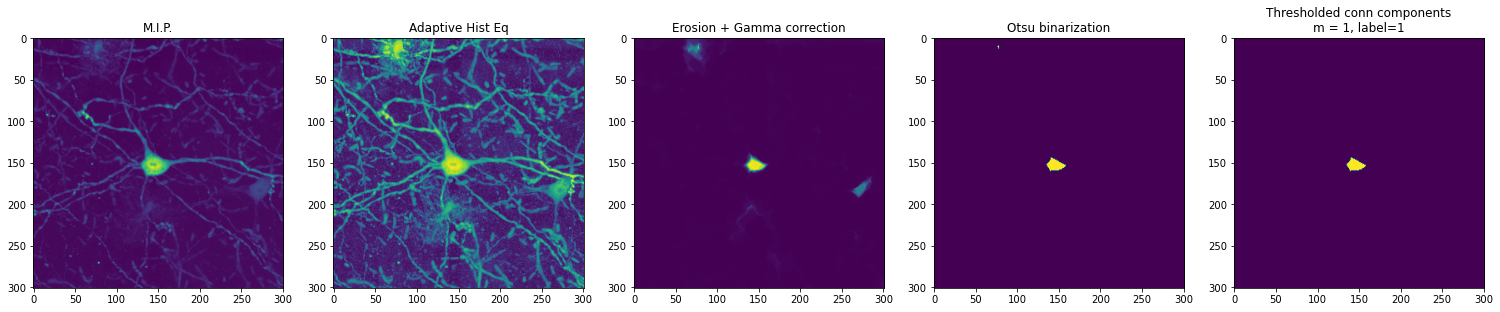

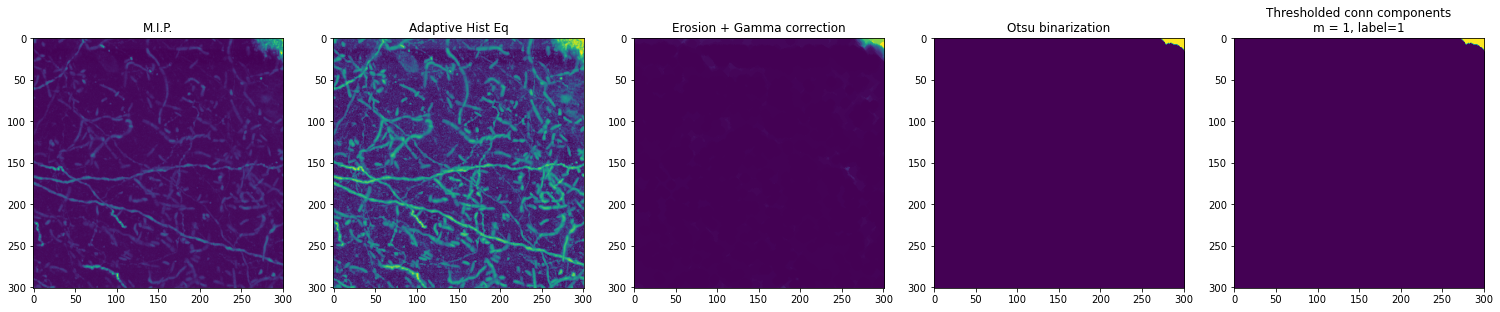

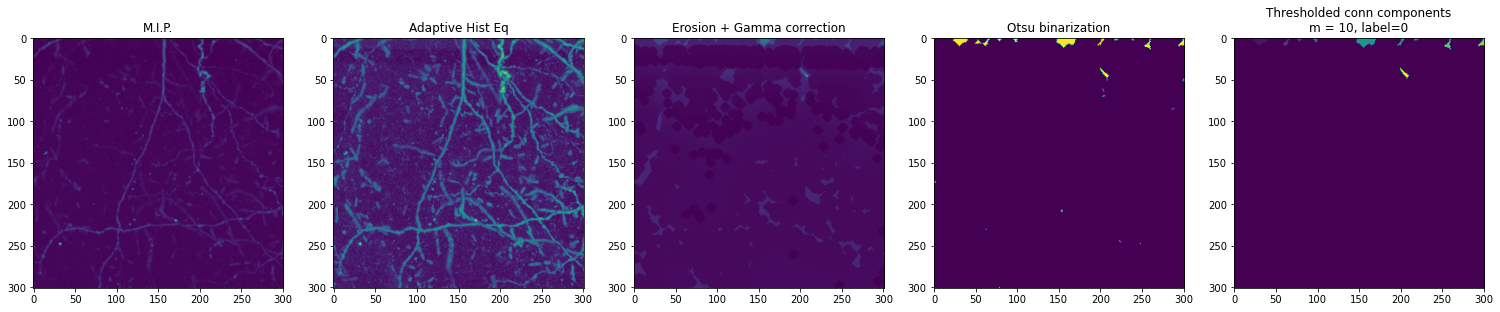

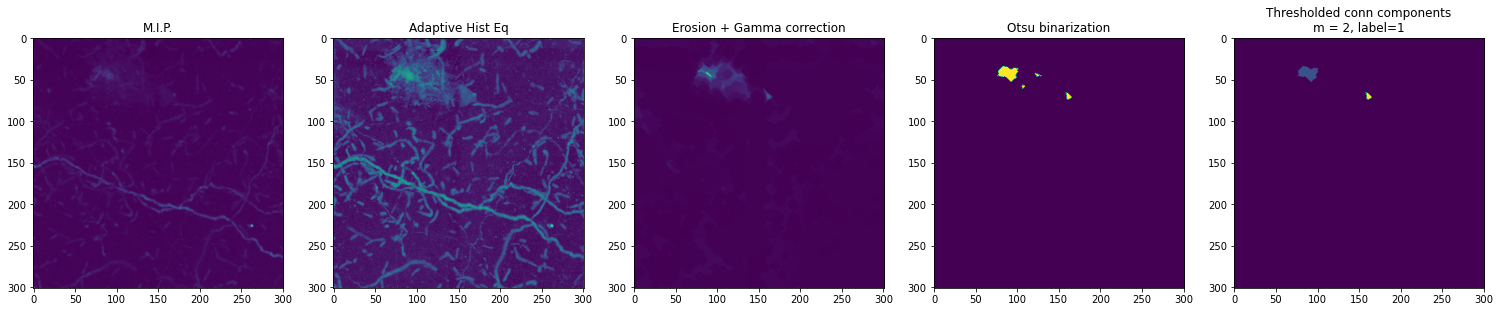

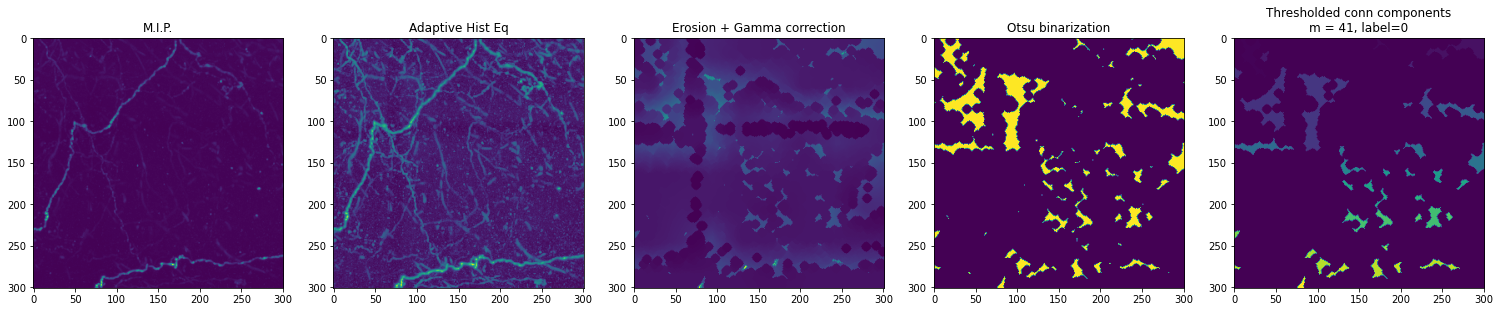

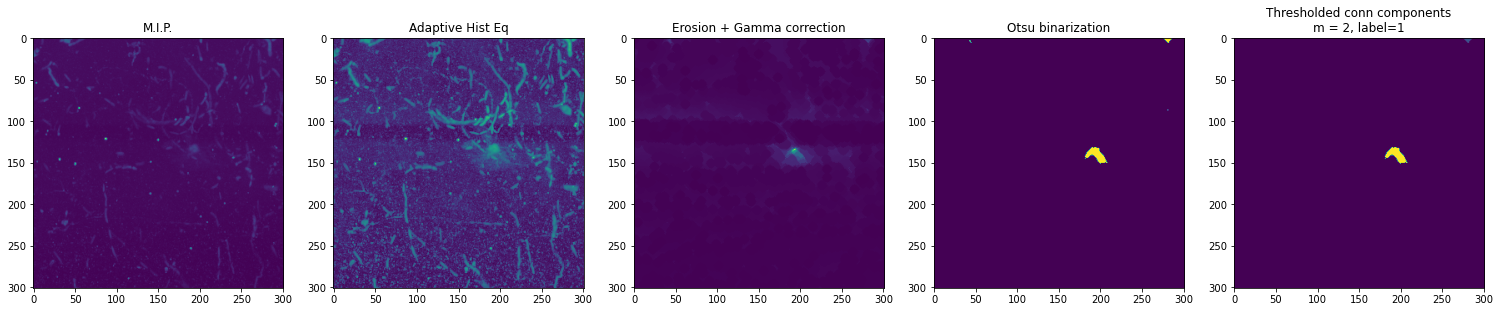

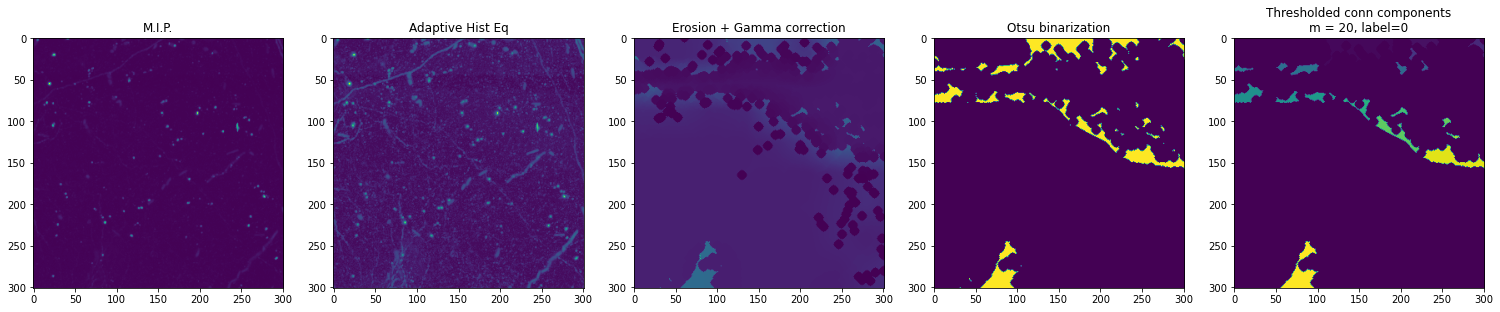

KeyboardInterrupt: 

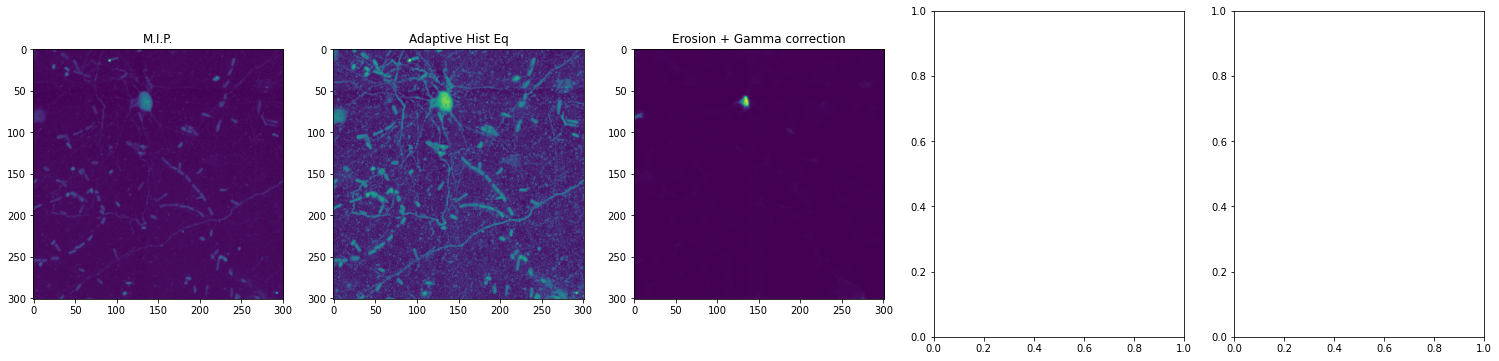

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
from pathlib import Path
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, exposure, util
)

radius = 150
neigh_n = 6

root_dir = Path(os.path.abspath('')).parents[1]
exp_dir = os.path.join(root_dir, "soma_detection")
data_dir = os.path.join(exp_dir, "data")
volumes_dir = os.path.join(data_dir, "volumes", str(radius))
print(f"Volumes dir {volumes_dir}")

brains = [1]
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("open-neurodata")

def contains_somas(img):
    fig = plt.figure(figsize=(26, 6))
    axes = fig.subplots(1, 5)
    
    out = img.copy()
    out = np.amax(img, axis=2)
    ax = axes[0]
    ax.imshow(out)
    ax.set_title("M.I.P.")
    
    out = exposure.equalize_adapthist(out, clip_limit=0.03)
    ax = axes[1]
    ax.imshow(out)
    ax.set_title("Adaptive Hist Eq")
    # out = exposure.adjust_gamma(out, gamma=1.5)
    # mean = np.mean(img.flatten())
    # std = np.std(img.flatten())
    # img = (img - mean)/std
    # small_selem =  morphology.diamond(2)
    soma_selem = morphology.disk(3)
    clean_selem = morphology.diamond(2)
    cclean_selem = morphology.diamond(1)
    
    out = morphology.erosion(out, soma_selem)
    out = morphology.erosion(out, clean_selem)
    out = morphology.erosion(out, cclean_selem)
    out = exposure.adjust_gamma(out, gamma=1.5)

    
    ax = axes[2]
    ax.imshow(out)
    ax.set_title("Erosion + Gamma correction")
    
    ts = filters.threshold_multiotsu(out)
    out = np.digitize(out, bins=ts)
    out = out == 2
    # t = filters.threshold_otsu(out)
    # out = out > t
    
    ax = axes[3]
    ax.imshow(out)
    ax.set_title("Otsu binarization")
    
    out, labels = morphology.label(out, background=0, return_num=True)
    for label in np.arange(1, labels+1):
        A = np.sum(out.flatten() == label)
        # print(label, A)
        if A < 20 or A > 2500:
            out[out == label] = 0
    
    labels, m = morphology.label(out, background=0, return_num=True)
    label = 0 if (m==0 or m >= 7) else 1
    
    ax = axes[4]
    ax.imshow(out)
    ax.set_title(f"Thresholded conn components\nm = {m}, label={label}")

    plt.show()
    return label, out

for brain in brains:
    brain_name = "brain%d" % brain

    brain_prefix = f"brainlit/{brain_name}"
    segments_prefix = f"brainlit/{brain_name}_segments"
    skeletons_prefix = f"{segments_prefix}/skeletons"

    brain_url = f"s3://open-neurodata/{brain_prefix}"
    segments_url = f"s3://open-neurodata/{segments_prefix}"

    for i, seg_obj in enumerate(bucket.objects.filter(Prefix=skeletons_prefix)):
        seg_id = os.path.basename(seg_obj.key)
        if seg_id != "info":
            # fig = plt.figure(figsize=(26, 6))
            # axes = fig.subplots(2, neigh_n + 1)
            
            # print root volume
            volume_filepath = os.path.join(volumes_dir, brain_name, f"{seg_id}.npy")
            img = np.load(volume_filepath, allow_pickle=True)
            
            # mean = np.mean(img.flatten())
            # std = np.std(img.flatten())
            # img = (img-mean)/std
            
            # proj = np.amax(img, axis=2)
            label, somas = contains_somas(img)
            # ax = axes[0, 0]
            # ax.imshow(proj)
            # ax.set_title(label)
            # ax = axes[1, 0]
            # ax.imshow(somas)
            
            # print neighbors
            for neigh_id in np.arange(neigh_n):
                neighvolume_filepath = os.path.join(volumes_dir, brain_name, f"{seg_id}_neigh{neigh_id}.npy")
                neighimg = np.load(neighvolume_filepath, allow_pickle=True)
                
                # neighmean = np.mean(neighimg.flatten())
                # neighstd = np.std(neighimg.flatten())
                # neighimg = (neighimg - neighmean)/neighstd
                
                # neighproj = np.amax(neighimg, axis=2)
                neigh_label, neigh_somas = contains_somas(neighimg)
                # ax = axes[0, neigh_id + 1]
                # ax.imshow(neighproj)
                # ax.set_title(neigh_label)
                # ax = axes[1, neigh_id + 1]
                # ax.imshow(neigh_somas)
                
        plt.show()